In [126]:
# going to see how to load physionet16 and interact with its data while my model takes an hour to train

In [182]:
from scipy.io import wavfile
from scipy import signal
from time import time
import random
import librosa
import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

In [183]:
physio16_path = '/Users/donu/Desktop/S25/ELEC 594/datasets/physio16/'
physio_anno_path = physio16_path +'annotations/Online_Appendix_training_set.csv'

In [184]:
physio16_data  = pd.read_csv(physio_anno_path)
num_recordings = physio16_data.shape[0]

In [185]:
physio16_data

,Challenge record name,Database,Original record name,Diagnosis,Class (-1=normal 1=abnormal),# Beat (automated algorithm),# Beats requiring hand correction,Gender,Age (year),Height (m),...,# Recording in each subject,Transducer site on body,Recording state,Murmurs (2=None 3=Weak 4=Strong 6=Unclear),"Murmur Location (2=Sys,3=Dia,4=Both)",Arrhythmia (2=None 3=One arrhythmic beat 4=Medium Arrhytmia 5=Severe Arrhytmia 6=Unclear 7=Two arrhythmic beats),Respiration noise (2=None 3=Insignificant 4=Weak Resp. Noise<2 s 5=Weak Resp. Noise<3 s 6=Weak Resp. Noise <4 s 7=Weak Resp. Noise >4 s 8=Powerfull Resp. Noise<2 s 9=Powerfull Resp. Noise<3 s 10=Powerfull Resp. noise <4 s 11=Powerfull Resp. Noise >4 s 12=Dont know 13=Weak Resp. Noise<1 s 14=Resp. Noise<1 s 15=Powerfull Resp. noise <1 s 16=Weak Rec. Noise<1 s 17=Powerfull Rec. Noise<1 s),Ambient noise (2=None 3=Insignificant 4=Weak Rec. BG<2 s 5=Weak Rec. BG<3 s 6=Weak Rec. BG <4 s 7=Weak Rec. BG >4 s 8=BG. Noise<2 s 9=BG. Noise<3 s 10= BG. noise <4 s 11=BG. Noise >4 s 12=Powerfull BG. Noise<2 s 13=Powerfull BG. Noise<3 s 14=Powerfull BG. noise <4 s 15=Powerfull BG. Noise >4 s 16=Dont know 17=Weak BG. Noise<1 s 18=BG.Noise<1 s 19=Powerfull BG. Noise<1 s),Recording noise (2=None 3=Insignificant 4=Beg. Rec. Noise 5=End Rec. Noise 6=Beg-End Reco Noise 7=Weak Rec. Noise<2 s 8=Weak Rec. Noise<3 s 9=Weak Rec. Noise <4 s 10=Weak Rec. Noise >4 s 11=Powerfull Rec. Noise<2 s 12=Powerfull Rec. Noise<3 s 13=Powerfull Rec. noise <4 s 14=Powerfull Rec. Noise >4 s 15=Spikes 16=Dont know 17=Weak Rec. Noise<1 s 18=Powerfull Rec. Noise<1 s),Abdominal sounds (2=None 3=Insignificant 4=Sto. Noise<2 s 5=Sto. Noise<3 s 6=Sto. Noise <4 s 7=Sto. Noise >4 s 8=Dont know 9=Sto. Noise<1 s)
0,a0001,training-a,C45S1,MVP,1,36,0,NaN,NaN,NaN,...,NaN,Left of parasternum,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,a0002,training-a,C19S3,MVP,1,27,7,NaN,NaN,NaN,...,NaN,Parasternum when sit,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,a0003,training-a,C23S0,MVP,1,25,0,NaN,NaN,NaN,...,NaN,Left of parasternum,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,a0004,training-a,C35S18,Benign,1,35,0,NaN,NaN,NaN,...,NaN,Left of parasternum,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,a0005,training-a,C63S20,Benign,1,52,0,NaN,NaN,NaN,...,NaN,Parasternum when squat,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3148,f0110,training-f,a110,Normal,-1,46,0,F,27.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3149,f0111,training-f,a111,Normal,-1,51,0,F,58.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3150,f0112,training-f,a112,Normal,-1,21,21,M,71.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3151,f0113,training-f,a68-1,Normal,-1,32,15,M,26.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 1 - Data exploration

### 1.a - Find murmurs

In [186]:
normal_str = "Class (-1=normal 1=abnormal)"
murmur_str = "Murmurs (2=None 3=Weak 4=Strong 6=Unclear)"

In [187]:
type(np.unique(physio16_data[murmur_str])[-1])

numpy.float64

In [188]:
np.sum(~pd.isna(physio16_data[murmur_str]))

490

In [189]:
physio16_data.shape

(3153, 26)

In [190]:
np.sum(physio16_data[normal_str]==1) # 665 abnormal

665

In [191]:
100*np.sum(physio16_data[normal_str]==1)/3153 # percent abnormal

21.091024421186173

In [192]:
just_murmurs = physio16_data.loc[~pd.isna(physio16_data[murmur_str])] # where murmurs are

In [193]:
np.sum(just_murmurs[normal_str]==1)/np.sum(just_murmurs[normal_str]!=0)
# prevalence of murmurs basically uncorrelated with presence of heart abnormalities in this dataset
# this is very strange...

0.21224489795918366

In [194]:
physio16_data['Database'].unique() # physio16_path+this value+ 'Challenge record name' value

array(['training-a', 'training-b', 'training-c', 'training-d',
       'training-e', 'training-f'], dtype=object)

In [195]:
murmur_str # this tells you what the numbers mean. want to find where murmurs are

'Murmurs (2=None 3=Weak 4=Strong 6=Unclear)'

In [207]:
murmur_locs = physio16_data[murmur_str]>2 # !impt: >=1 vs >=0. a lot are just 0

In [206]:
sum(physio16_data[murmur_str]>2) # 2=none, 3=weak, 4=strong

78

In [208]:
np.sum(murmur_locs)

78

In [209]:
murmur_present = physio16_data.loc[murmur_locs] # there are definitely murmurs in these recordings
murmur_present = murmur_present.reset_index()
murmur_count = murmur_present.shape[0]

In [210]:
# proportion of murmur recordings that are associated with abnormal heartbeats
np.sum(murmur_present[normal_str]==1)/np.sum(murmur_present[normal_str]!=0)
# !impt: if >=1 was used this will be 1. otherwise it will be like 0.2 

1.0

### 1.b - Find normal recordings

In [211]:
normal_recordings = physio16_data[~murmur_locs] # any of these
normal_recordings.reset_index()

,index,Challenge record name,Database,Original record name,Diagnosis,Class (-1=normal 1=abnormal),# Beat (automated algorithm),# Beats requiring hand correction,Gender,Age (year),...,# Recording in each subject,Transducer site on body,Recording state,Murmurs (2=None 3=Weak 4=Strong 6=Unclear),"Murmur Location (2=Sys,3=Dia,4=Both)",Arrhythmia (2=None 3=One arrhythmic beat 4=Medium Arrhytmia 5=Severe Arrhytmia 6=Unclear 7=Two arrhythmic beats),Respiration noise (2=None 3=Insignificant 4=Weak Resp. Noise<2 s 5=Weak Resp. Noise<3 s 6=Weak Resp. Noise <4 s 7=Weak Resp. Noise >4 s 8=Powerfull Resp. Noise<2 s 9=Powerfull Resp. Noise<3 s 10=Powerfull Resp. noise <4 s 11=Powerfull Resp. Noise >4 s 12=Dont know 13=Weak Resp. Noise<1 s 14=Resp. Noise<1 s 15=Powerfull Resp. noise <1 s 16=Weak Rec. Noise<1 s 17=Powerfull Rec. Noise<1 s),Ambient noise (2=None 3=Insignificant 4=Weak Rec. BG<2 s 5=Weak Rec. BG<3 s 6=Weak Rec. BG <4 s 7=Weak Rec. BG >4 s 8=BG. Noise<2 s 9=BG. Noise<3 s 10= BG. noise <4 s 11=BG. Noise >4 s 12=Powerfull BG. Noise<2 s 13=Powerfull BG. Noise<3 s 14=Powerfull BG. noise <4 s 15=Powerfull BG. Noise >4 s 16=Dont know 17=Weak BG. Noise<1 s 18=BG.Noise<1 s 19=Powerfull BG. Noise<1 s),Recording noise (2=None 3=Insignificant 4=Beg. Rec. Noise 5=End Rec. Noise 6=Beg-End Reco Noise 7=Weak Rec. Noise<2 s 8=Weak Rec. Noise<3 s 9=Weak Rec. Noise <4 s 10=Weak Rec. Noise >4 s 11=Powerfull Rec. Noise<2 s 12=Powerfull Rec. Noise<3 s 13=Powerfull Rec. noise <4 s 14=Powerfull Rec. Noise >4 s 15=Spikes 16=Dont know 17=Weak Rec. Noise<1 s 18=Powerfull Rec. Noise<1 s),Abdominal sounds (2=None 3=Insignificant 4=Sto. Noise<2 s 5=Sto. Noise<3 s 6=Sto. Noise <4 s 7=Sto. Noise >4 s 8=Dont know 9=Sto. Noise<1 s)
0,0,a0001,training-a,C45S1,MVP,1,36,0,NaN,NaN,...,NaN,Left of parasternum,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,a0002,training-a,C19S3,MVP,1,27,7,NaN,NaN,...,NaN,Parasternum when sit,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,a0003,training-a,C23S0,MVP,1,25,0,NaN,NaN,...,NaN,Left of parasternum,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,a0004,training-a,C35S18,Benign,1,35,0,NaN,NaN,...,NaN,Left of parasternum,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,a0005,training-a,C63S20,Benign,1,52,0,NaN,NaN,...,NaN,Parasternum when squat,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3070,3148,f0110,training-f,a110,Normal,-1,46,0,F,27.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3071,3149,f0111,training-f,a111,Normal,-1,51,0,F,58.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3072,3150,f0112,training-f,a112,Normal,-1,21,21,M,71.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3073,3151,f0113,training-f,a68-1,Normal,-1,32,15,M,26.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 1.c Select good examples for both murmur and non-murmur

In [212]:
# want like, 3 good murmur and non-murmur recordings for visualization purposes
# visualization here

# from the other ipynb
def load_from_filepath(filepath):
    """
    Load an audio file from a given file path and return the audio data and sample rate.
    """
    audio_data, sample_rate = librosa.load(filepath,sr=None)
    return audio_data, sample_rate


In [213]:
murmur_present.shape

(78, 27)

training-b/b0008
training-b/b0016
training-b/b0018


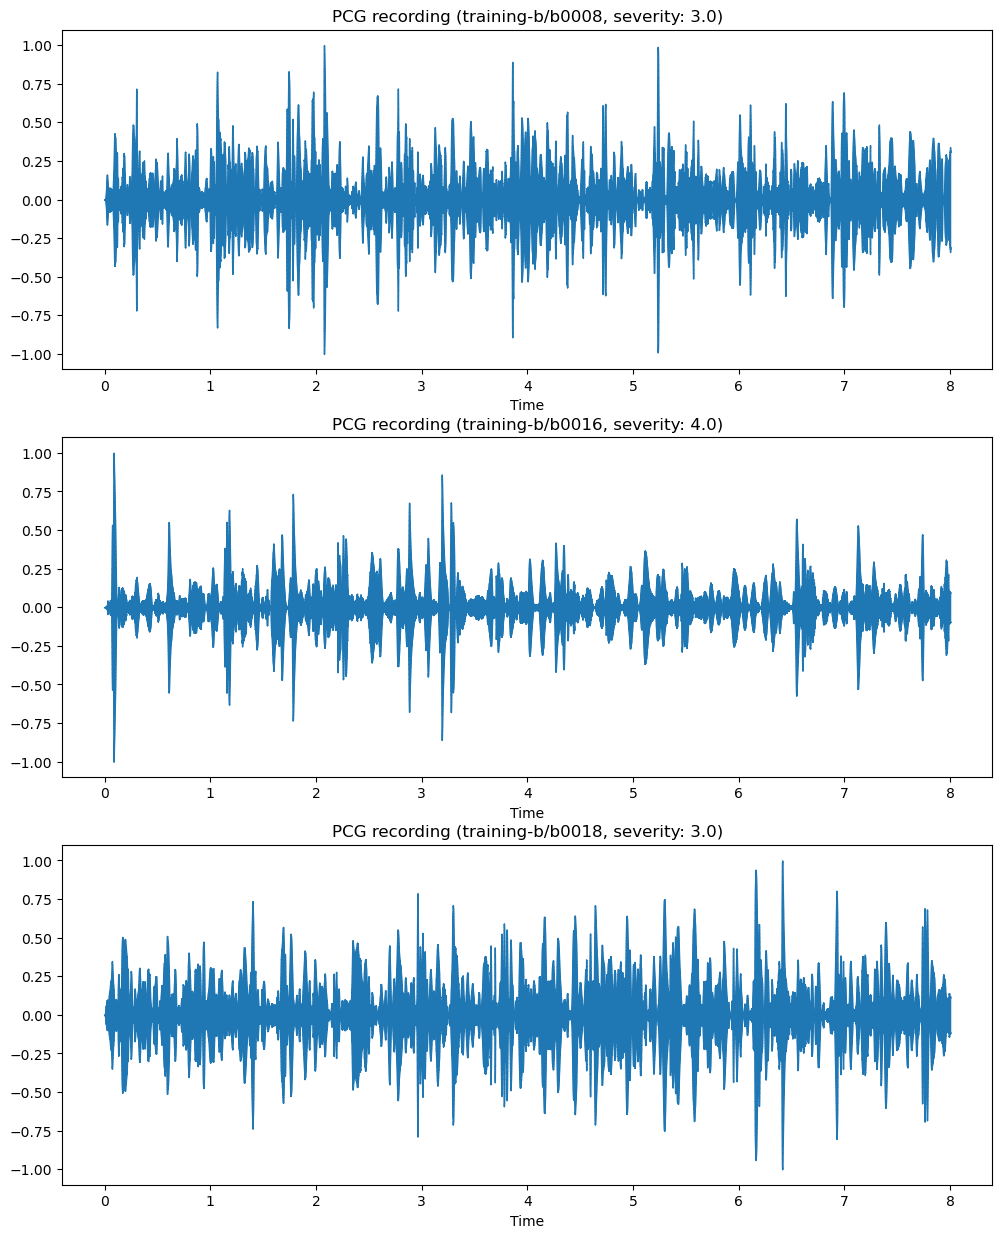

In [224]:
# looking for clean recordings
# change between "murmur_present" and "normal_recordings" to see murmured vs normal recordings
num_to_show = 3
start_idx = 0
fig, ax = plt.subplots(nrows=num_to_show, figsize=(12, 5*num_to_show))

#general plotting
for rowidx,row in murmur_present.iterrows():
  if start_idx<=rowidx<start_idx+num_to_show:
    relidx = rowidx-start_idx
    fname = murmur_present.iloc[rowidx]['Challenge record name']
    subdir =  murmur_present.iloc[rowidx]['Database']
    fpath = physio16_path+f'{subdir}/{fname}.wav'
    print(subdir + '/'+ fname)
    data, sr = load_from_filepath(fpath)
    severity = murmur_present.iloc[rowidx][murmur_str]
    ax[relidx].set(title=f'PCG recording ({subdir+"/"+fname}, severity: {severity})')
    #ax[1].set(title='PCG+Noise')
    librosa.display.waveshow(data,sr=sr,ax=ax[relidx])
    #librosa.display.waveshow(composite,sr=target_freq,ax=ax[1])

# !impt: strange behavior here. plotting w/ waveshow generally has a range in [-1,1]
# ... however, if you take the max of the actual wav file it can be like 0.7
# ... i was concerned since the zoomed in waveforms don't match the regular waveforms
# ... but the regular waveforms dont even match the regular data bruh

### Code to print zoomed in versions:
#print('---')
#fig, ax = plt.subplots(nrows=num_to_show, figsize=(12, 5*num_to_show))
## # want to show the same length for all of them actually. 3 seconds. 
#good_idx = 0
#for rowidx,row in murmur_present.iloc[start_idx:,:].iterrows():
#  if num_to_show<=good_idx: 
#    break
#  # recording name and type
#  fname = murmur_present.iloc[rowidx]['Challenge record name']
#  subdir =  murmur_present.iloc[rowidx]['Database']
#  fpath = physio16_path+f'{subdir}/{fname}.wav'
#  # load the data
#  data, sr = load_from_filepath(fpath)
#  length_of_rec = len(data)/sr
#  # want to plot the same length for all recordings
#  if length_of_rec<=3: 
#    continue
#  # good to plot
#  print(subdir+'/'+fname, "(murmur)")
#  #print(max(data))
#  ax[good_idx].set(title=f'PCG recording, zoomed in ({subdir+"/"+fname})')
#  #ax[1].set(title='PCG+Noise')
#  librosa.display.waveshow(data[:sr*3],sr=sr,ax=ax[good_idx]) # original data
#  good_idx+=1
  
# i have looked at 74 murmured heartbeats and they are all barely interpretable to me...

In [148]:
# Q: 
# # Why is it that all of these recordings are so noisy seeming/ is this a realistic level of noise?
# # Does this problem go away when plotting with scipy? Let's confirm...

In [149]:
normal_recordings.shape

(3077, 26)

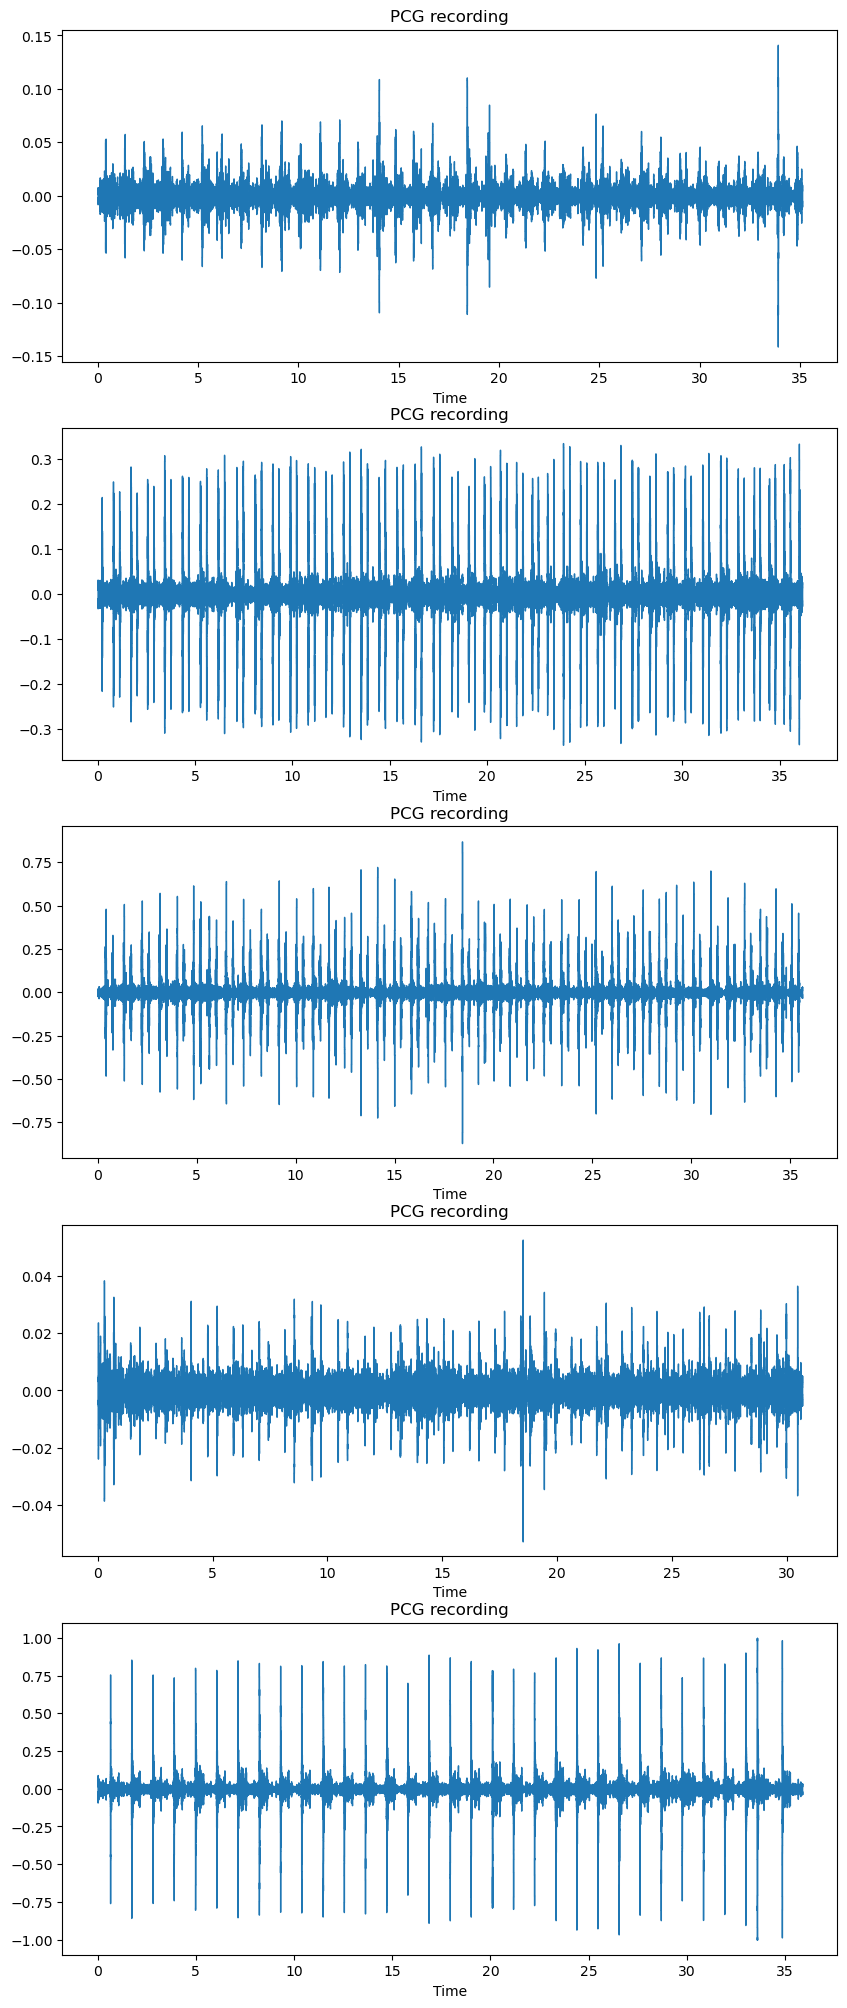

In [150]:
# Plotting with scipy
how_many_to_show=5
what_idx_to_start =40
fig, ax = plt.subplots(nrows=how_many_to_show, figsize=(10, 5*how_many_to_show))

for rowidx,row in normal_recordings.iterrows():
  if what_idx_to_start<=rowidx<what_idx_to_start+how_many_to_show:
    relidx = rowidx-what_idx_to_start
    fname = normal_recordings.iloc[rowidx]['Challenge record name']
    subdir =  normal_recordings.iloc[rowidx]['Database']
    fpath = physio16_path+f'/{subdir}/{fname}.wav'
    data, sr = load_from_filepath(fpath)
    ax[relidx].set(title='PCG recording')
    #ax[1].set(title='PCG+Noise')
    librosa.display.waveshow(data,sr=sr,ax=ax[relidx])
    #librosa.display.waveshow(composite,sr=target_freq,ax=ax[1])
# these generally look much better. 
# thinking about what examples can be used...

In [151]:
# what now: 
# 0. make the clips shorter. s1 vs s2 should be good. 
# 0.5. once you do that look for the best exemplars from murmured heartbeats (murmur should be visible
# ... and also non-murmured)
# 1. move them to the other ipynb as a part of the pipeline.abs
# 1.5. want quantitative results
# 2. move them to